In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
path = "../input/" # for kaggle
df = pd.read_csv("insurance.csv")
print(f"Shape: {df.shape}")

df.head()

Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
# Make sure we don't have any null values
df[df.isnull().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges


In [5]:
corr = df.corr(method="pearson",numeric_only=True)
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


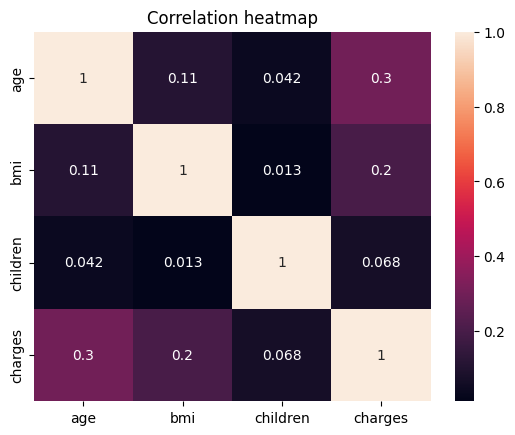

In [6]:
sns.heatmap(corr,annot=True)
plt.title("Correlation heatmap")
plt.show()

 There is no correlation between the variables.

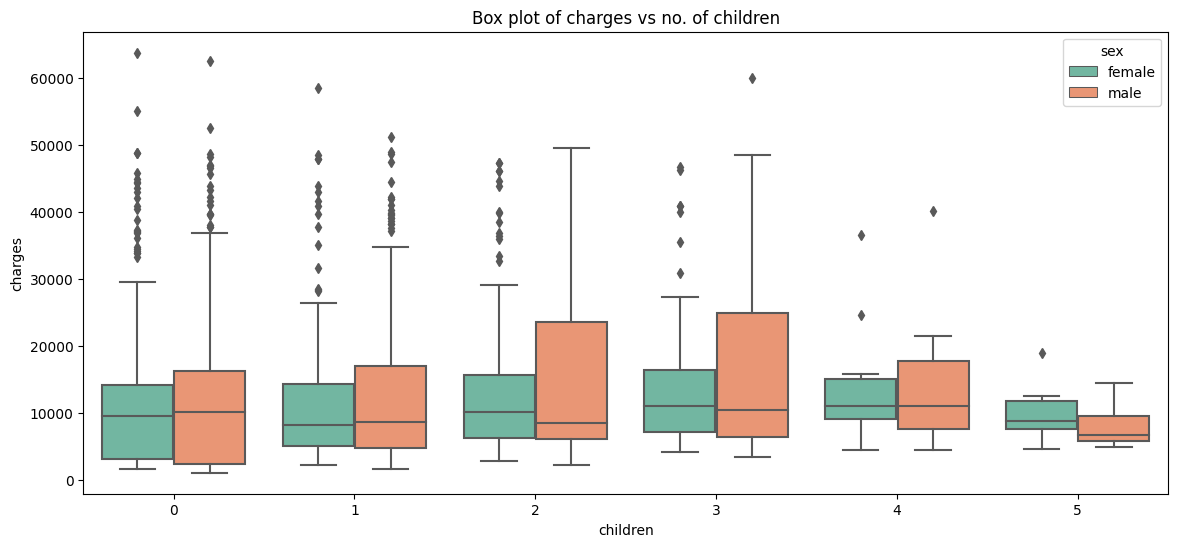

In [11]:
plt.figure(figsize=(14,6))
sns.boxplot(x="children",y="charges",hue="sex",data=df,palette="Set2")
plt.title("Box plot of charges vs no. of children")
plt.show()

In [12]:
child_charges = df.loc[:,["children","charges"]]
child_charges.head()

,children,charges
0,0,16884.92400
1,1,1725.55230
2,3,4449.46200
3,0,21984.47061
4,0,3866.85520


In [13]:
child_charges.groupby("children").agg(["mean","min","max"])["charges"]

,mean,min,max
children,,,
0,12365.975602,1121.8739,63770.42801
1,12731.171832,1711.0268,58571.07448
2,15073.563734,2304.0022,49577.66240
3,15355.318367,3443.0640,60021.39897
4,13850.656311,4504.6624,40182.24600
5,8786.035247,4687.7970,19023.26000


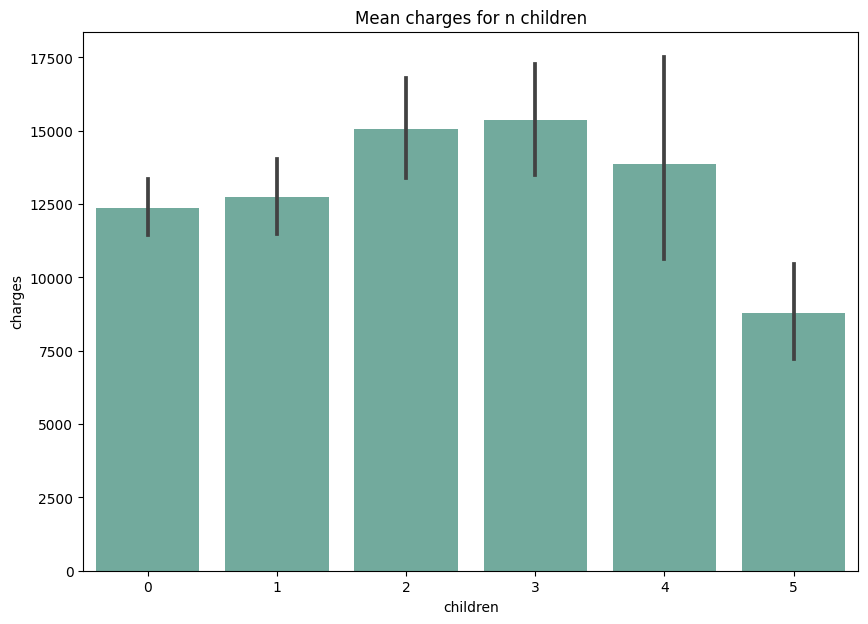

In [14]:
# Aggregate mean values for each n children
plt.figure(figsize=(10,7))
sns.barplot(data=child_charges,x="children",y="charges",color='#69b3a2')
plt.title("Mean charges for n children")
plt.show()

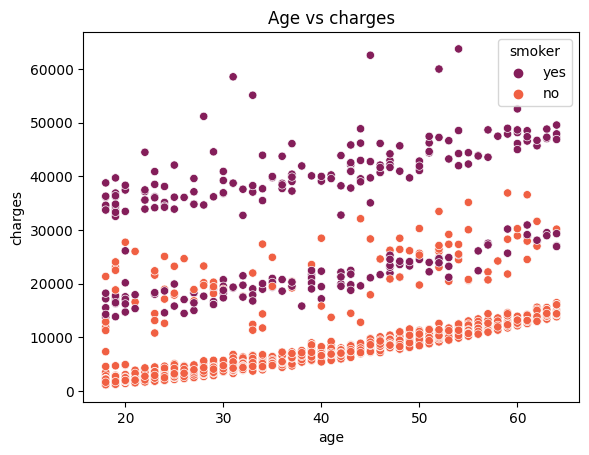

In [15]:
sns.scatterplot(data=df,x="age",y="charges",hue="smoker",palette="rocket")
plt.title("Age vs charges")
plt.show()

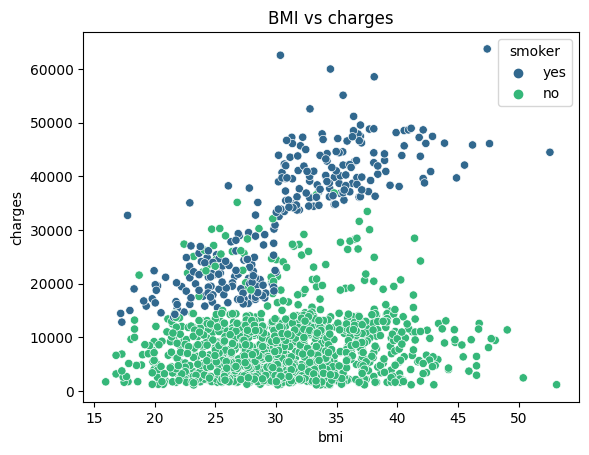

In [16]:
sns.scatterplot(data=df,x="bmi",y="charges",hue="smoker",palette="viridis")
plt.title("BMI vs charges")
plt.show()

In [17]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


 Let's create a new age_cat variable, make age a categorical var.

 * Young Adult: 18 - 35
 * Adult: 36 - 55
 * Elder: 56 or older

In [18]:
df["age_cat"] = np.nan
age_categories = ["Young Adult", "Adult", "Elder"]

for col in [df]:
  col.loc[(col["age"] >= 18) & (col["age"] <= 35), "age_cat"] = age_categories[0]
  col.loc[(col["age"] >= 36) & (col["age"] <= 55), "age_cat"] = age_categories[1]
  col.loc[col["age"] >= 56, "age_cat"] = age_categories[2]

df.head()

,age,sex,bmi,children,smoker,region,charges,age_cat
0,19,female,27.900,0,yes,southwest,16884.92400,Young Adult
1,18,male,33.770,1,no,southeast,1725.55230,Young Adult
2,28,male,33.000,3,no,southeast,4449.46200,Young Adult
3,33,male,22.705,0,no,northwest,21984.47061,Young Adult
4,32,male,28.880,0,no,northwest,3866.85520,Young Adult


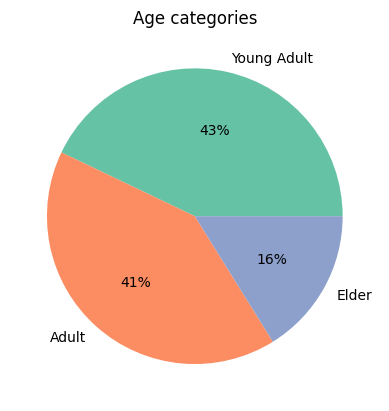

In [19]:
labels = df["age_cat"].unique().tolist()
amount = df["age_cat"].value_counts().tolist()

# ["#ff9999", "#b3d9ff", " #e6ffb3"]

plt.pie(x=amount,labels=labels,colors=sns.color_palette("Set2"),autopct='%.0f%%')
plt.title("Age categories")
plt.show()

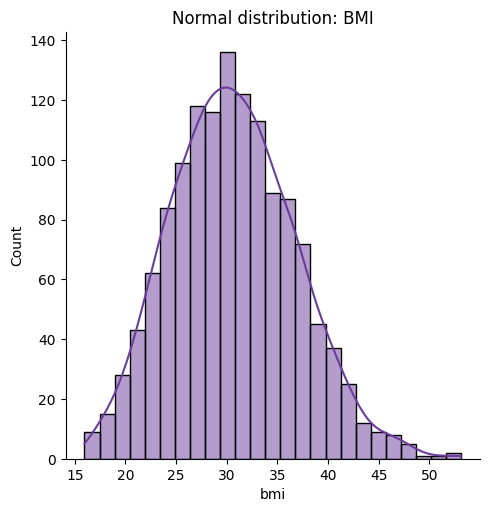

In [20]:
sns.displot(data=df,x=df["bmi"],kde=True,color="#6a3d9a")
plt.title("Normal distribution: BMI")
plt.show()

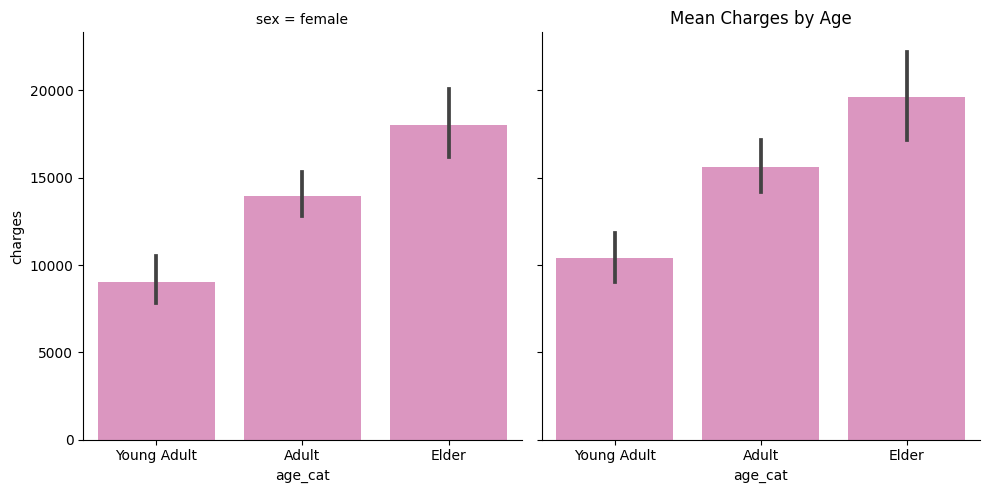

In [21]:
sns.catplot(data=df,x="age_cat",y="charges",kind="bar",col="sex",palette=["#e78ac3"])
plt.title("Mean Charges by Age")
plt.show()

 Mean could be affected easily by outliers, so we take median values as well.

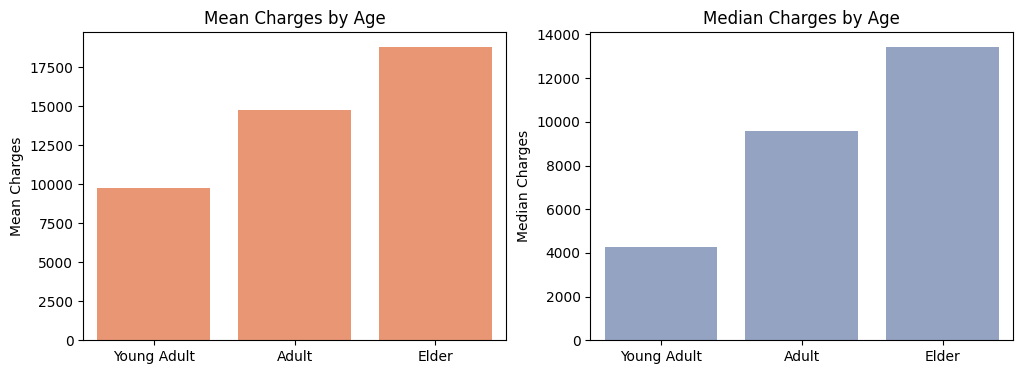

In [22]:
mean_charges = []
median_charges = []

for cat in age_categories:
  mean_charges.append(df["charges"].loc[df["age_cat"] == cat].mean())
  median_charges.append(df["charges"].loc[df["age_cat"] == cat].median())

f = plt.figure(figsize=(12,4))

ax = f.add_subplot(121)
sns.barplot(x=age_categories,y=mean_charges,color="#fc8d62",ax=ax)
ax.set_ylabel("Mean Charges")
ax.set_title("Mean Charges by Age")

ax = f.add_subplot(122)
sns.barplot(x=age_categories,y=median_charges,color="#8da0cb")
ax.set_ylabel("Median Charges")
ax.set_title("Median Charges by Age")

plt.show()

 [BMI Categories](https://www.cdc.gov/obesity/basics/adult-defining.html) defined by the Health Ministry of India:

 * Underweight: BMI < 18.5
 * Healthy: BMI >= 18.5 & BMI < 25
 * Overweight: BMI >= 25 & BMI < 30
 * Obesity: BMI >= 30

In [23]:
df["bmi_cat"] = np.nan
df.loc[(df["bmi"] < 18.5),"bmi_cat"] = "Underweight"
df.loc[(df["bmi"] >= 18.5) & (df["bmi"] < 25),"bmi_cat"] = "Healthy"
df.loc[(df["bmi"] >= 25) & (df["bmi"] < 30),"bmi_cat"] = "Overweight"
df.loc[(df["bmi"] >= 30),"bmi_cat"] = "Obesity"

df.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,bmi_cat
0,19,female,27.900,0,yes,southwest,16884.92400,Young Adult,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Young Adult,Obesity
2,28,male,33.000,3,no,southeast,4449.46200,Young Adult,Obesity
3,33,male,22.705,0,no,northwest,21984.47061,Young Adult,Healthy
4,32,male,28.880,0,no,northwest,3866.85520,Young Adult,Overweight


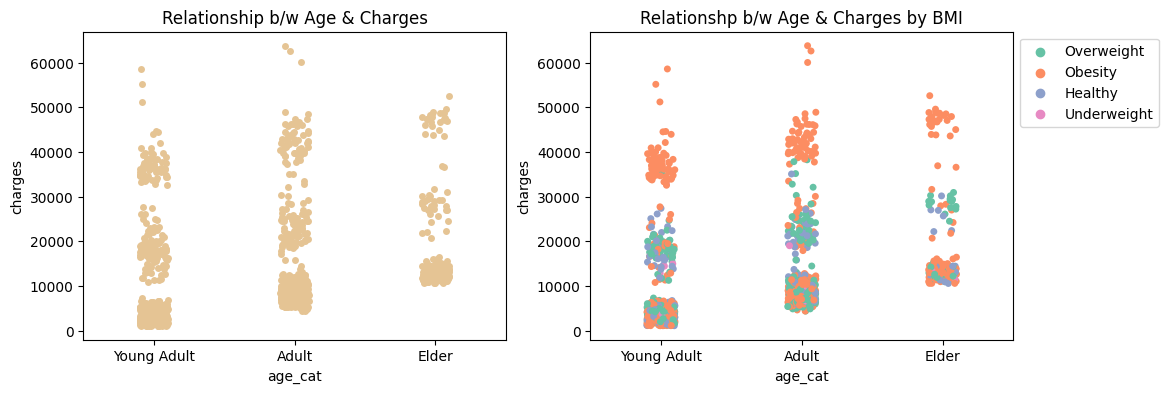

In [24]:
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

sns.stripplot(data=df,x="age_cat",y="charges",ax=ax1,color="#e5c494")
ax1.set_title("Relationship b/w Age & Charges")

sns.stripplot(data=df,x="age_cat",y="charges",hue="bmi_cat",ax=ax2,palette="Set2",legend="brief")
plt.legend(bbox_to_anchor=(1,1))
ax2.set_title("Relationshp b/w Age & Charges by BMI")

plt.show()

 The obese group is charged more insurance premium than other BMI groups.

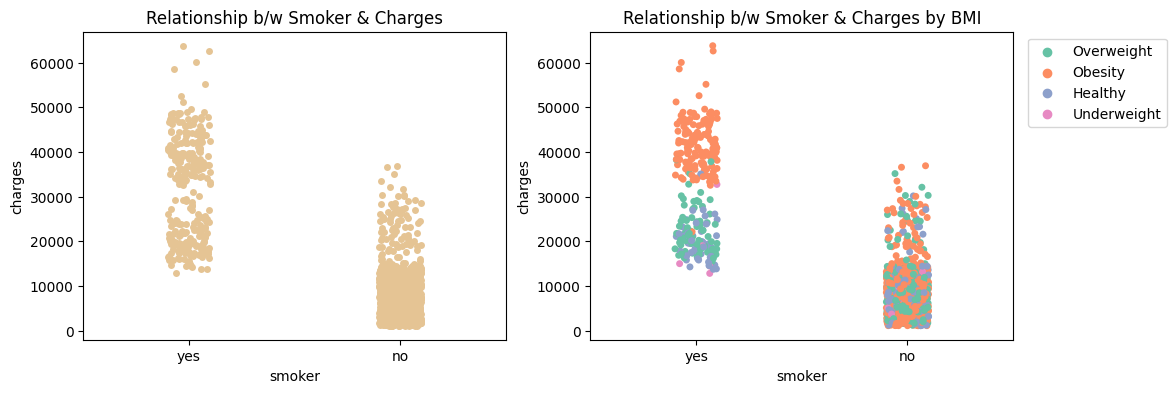

In [25]:
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

sns.stripplot(data=df,x="smoker",y="charges",ax=ax1,color="#e5c494")
ax1.set_title("Relationship b/w Smoker & Charges")

sns.stripplot(data=df,x="smoker",y="charges",hue="bmi_cat",ax=ax2,palette="Set2")
plt.legend(bbox_to_anchor=(1.38,1))
ax2.set_title("Relationship b/w Smoker & Charges by BMI")

plt.show()

 Obese smokers are the group that are charged the highest insurance premium.

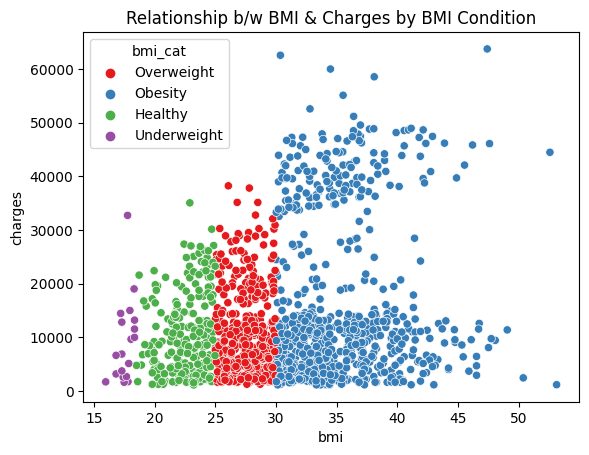

In [26]:
sns.scatterplot(data=df,x="bmi",y="charges",hue="bmi_cat",palette="Set1")
plt.title("Relationship b/w BMI & Charges by BMI Condition")
plt.show()

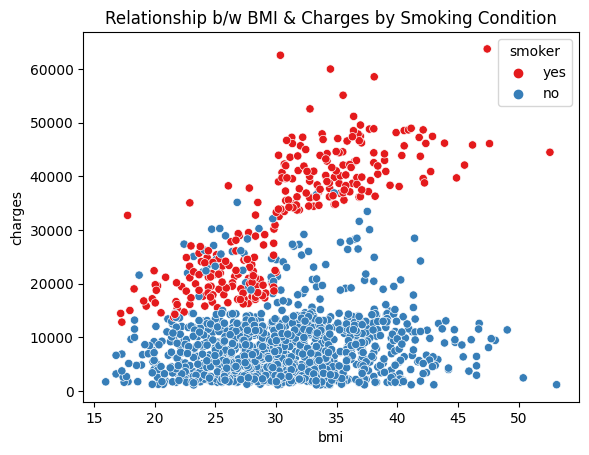

In [27]:
sns.scatterplot(data=df,x="bmi",y="charges",hue="smoker",palette="Set1")
plt.title("Relationship b/w BMI & Charges by Smoking Condition")
plt.show()

 By looking at the scatter plot, we can conclude that on average smokers are charged higher insurance premium.

 Now let's try to do a cluster analysis using k-means cluster. First we need to implement something called as the elbow method to find the optimal number of clusters or k.

In [28]:
X = df[["bmi", "charges"]]

# WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.
wcss = []
n_clusters_test = range(1,11)

for n in n_clusters_test:
  kmeans = KMeans(n_clusters=n,init="k-means++")
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

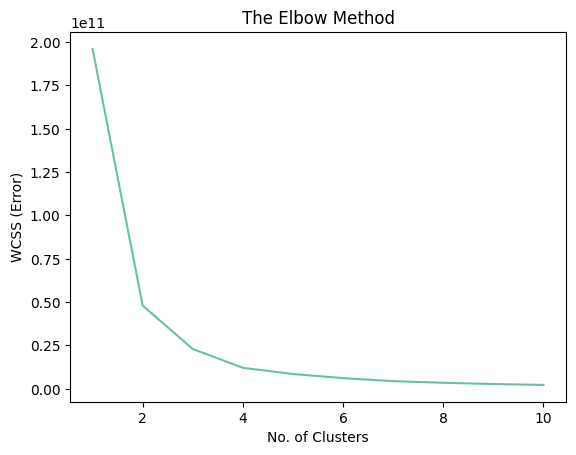

In [29]:
sns.lineplot(x=n_clusters_test,y=wcss,color="#66c2a5")
plt.title("The Elbow Method")
plt.xlabel("No. of Clusters")
plt.ylabel("WCSS (Error)")
plt.show()

 From the above line plot, we can conclude that after 3 clusters the WCSS isn't decreasing significantly.

In [30]:
kmeans = KMeans(n_clusters=3,init="k-means++")
kmeans.fit(X)

KMeans(n_clusters=3)

In [31]:
kmeans.cluster_centers_

array([[3.04318551e+01, 6.15645878e+03],
       [3.47535671e+01, 4.06230862e+04],
       [2.92042923e+01, 1.80517088e+04]])

In [32]:
kmeans.labels_

array([2, 0, 0, ..., 0, 0, 2], dtype=int32)

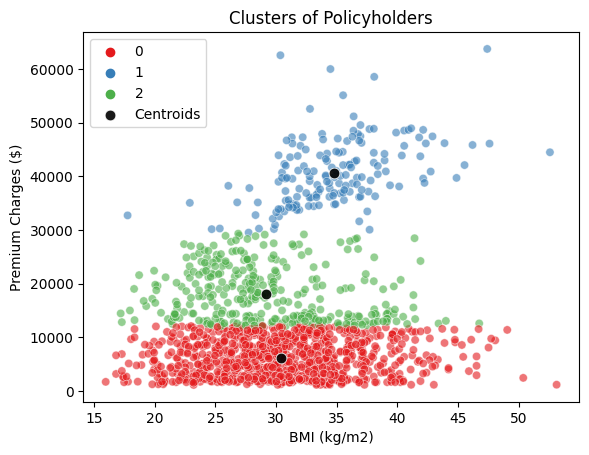

In [33]:
ax = sns.scatterplot(x=X.values[:,0],y=X.values[:,1],hue=kmeans.labels_,palette="Set1",alpha=0.6)

sns.scatterplot(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],ax=ax,s=60,color="black",label="Centroids",alpha=0.9)

plt.title("Clusters of Policyholders")
plt.xlabel("BMI (kg/m2)")
plt.ylabel("Premium Charges ($)")
plt.show()

 We can conclude that there are 3 clusters in the dataset.

In [34]:
df = pd.read_csv("insurance.csv")

categorical_data = ["sex","smoker","region"]
# OHE: One-Hot Encoding
df_encode = pd.get_dummies(data=df,prefix="OHE",prefix_sep="_",columns=categorical_data,drop_first=True)

df_encode.head()

,age,bmi,children,charges,OHE_male,OHE_yes,OHE_northwest,OHE_southeast,OHE_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [35]:
print(f"Columns in original data frame:\n{df.columns.values}")
print(f"\nShape: {df.shape}")
print(f"\nColumns in encoded data frame:\n{df_encode.columns.values}")
print(f"\nNew Shape: {df_encode.shape}")

Columns in original data frame:
['age' 'sex' 'bmi' 'children' 'smoker' 'region' 'charges']

Shape: (1338, 7)

Columns in encoded data frame:
['age' 'bmi' 'children' 'charges' 'OHE_male' 'OHE_yes' 'OHE_northwest'
 'OHE_southeast' 'OHE_southwest']

New Shape: (1338, 9)


 Let's check the distribution of our dependent variable: charges.
 We do this to know whether our dependent variable is normally distributed or not.

 A normally distributed dependent variable will yield us more accurate results.

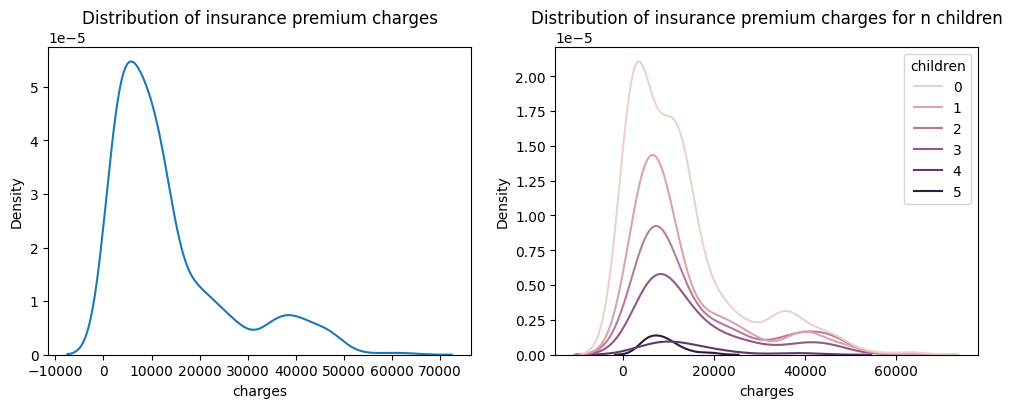

In [36]:
f= plt.figure(figsize=(12,4))

ax = f.add_subplot(121)
sns.kdeplot(data=df_encode,x="charges",ax=ax)
ax.set_title("Distribution of insurance premium charges")

ax = f.add_subplot(122)
sns.kdeplot(data=df_encode,x="charges",hue="children",ax=ax)
ax.set_title("Distribution of insurance premium charges for n children")

plt.show()

 We can clearly see that the premium charges, which is also our dependent variable, does not follow a normal distribution.

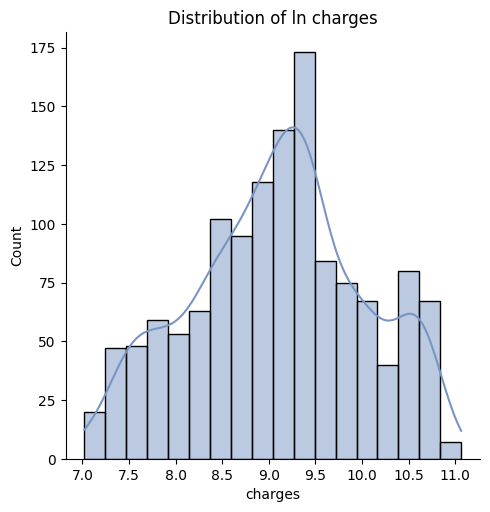

In [37]:
sns.displot(x=np.log(df_encode["charges"]),kde=True,color='#7995c4')
plt.title("Distribution of ln charges")
plt.show()

 By taking the log to the base 10 of the charges value, we get a normally distributed variable.

In [38]:
df_encode["log_charges"] = np.log(df_encode["charges"])

 Let's try a linear regression model.

In [49]:
X = df_encode.drop(["charges","log_charges"],axis=1)
y = df_encode["log_charges"].values.reshape(-1,1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [51]:
lin_reg = LinearRegression().fit(X_train,y_train)

In [52]:
theta = list(lin_reg.intercept_) + list(lin_reg.coef_.flatten())
params_df = pd.DataFrame({"Columns": ["intercept"]+list(X.columns.values),"Theta": theta})

params_df

,Columns,Theta
0,intercept,7.099999
1,age,0.035222
2,bmi,0.010684
3,children,0.099035
4,OHE_male,-0.082252
5,OHE_yes,1.529278
6,OHE_northwest,-0.085042
7,OHE_southeast,-0.162525
8,OHE_southwest,-0.142290


In [53]:
y_pred = lin_reg.predict(X_test)

print(f"Mean Squared Error: {mean_squared_error(y_test,y_pred):.4f}")
print(f"R squared: {r2_score(y_test, y_pred):.4f}")

Mean Squared Error: 0.2357
R squared: 0.7486


 The model returns R^2 value of about 75%, so it fits our data test very well, but we can still imporve the performance of by using a different technique.

 My personal data is used in the custom_test df.
 The data includes my age, bmi, children, smoker or not, etc.

In [54]:
custom_test = pd.DataFrame(columns=X_test.columns.values,data=[[22,21.5,0,1,0,0,0,1]])

prem_charges = lin_reg.predict(custom_test)
my_pred_charge = np.exp(prem_charges)[0][0]
print(f"My predicted premium charges: {my_pred_charge:.2f}")

My predicted premium charges: 2644.01


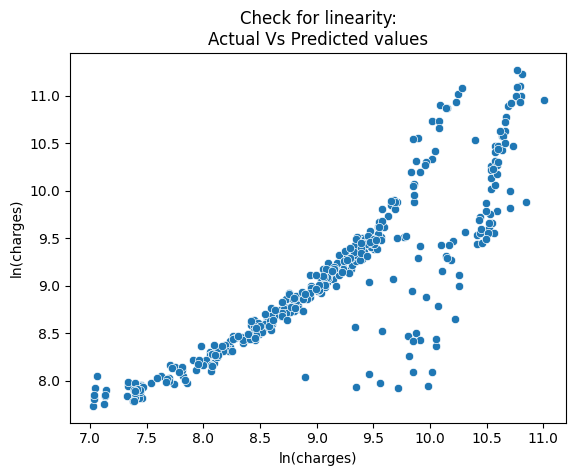

In [55]:
sns.scatterplot(x=y_test.flatten(),y=y_pred.flatten())
plt.title("Check for linearity:\nActual Vs Predicted values")
plt.xlabel("ln(charges)")
plt.ylabel("ln(charges)")
plt.show()

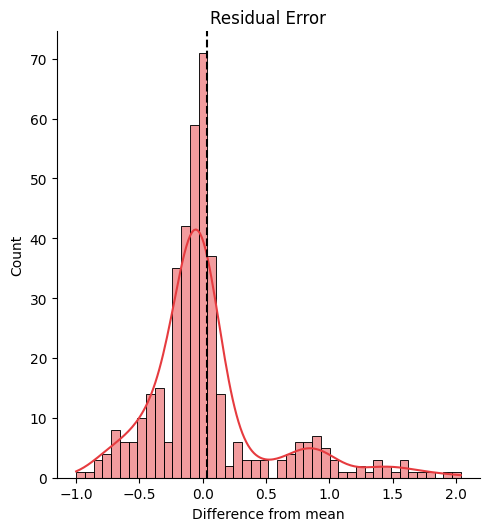

In [56]:
residual = y_test - y_pred
sns.displot(x=residual.flatten(),kde=True,color="#e63b3f")
plt.axvline(residual.mean(),linestyle="--",color="black")
plt.title("Residual Error")
plt.xlabel("Difference from mean")
plt.show()

 The mean for the above distribution plot is close to 0. Also, the residual mean is zero and residual error plot right skewed.